In [13]:
import ot
import numpy as np
import scanpy as sc
import scipy.sparse
import matplotlib.pyplot as plt
from scipy import optimize
from typing import Tuple
from anndata import AnnData


ad = sc.datasets.pbmc3k()
ad.X

<2700x32738 sparse matrix of type '<class 'numpy.float32'>'
	with 2286884 stored elements in Compressed Sparse Row format>

Roughly 3,000 peripheral blood mononuclear cells (PBMCs)
Roughly 32,000 genes per cell

(ROWS are cell embeddings in gene space)

In [ ]:
arr = ad.X.toarray()
print(arr)
print('shape', arr.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape (2700, 32738)


In [ ]:
print('number of genes measured per cell')
num_genes = np.sum(arr, axis=1)
print('average gene expression level:', np.mean(num_genes, axis=0), ', std: ', np.std(num_genes))
print('average proportion of genes activated', np.mean(num_genes, axis=0)/ 32738 )


number of genes measured per cell
average number of genes activated: 2366.9004 , std:  1094.0594
average proportion of genes activated 0.07229825861766144


In [ ]:
np.log(1 + arr)


In [ ]:
import math
print('basic count-normalizations')
arr_normed = (arr.T / num_genes).T
### np.sum(arr_normed, axis=1) # check that the rows are normalized now
### arr_normed = np.log(1 + arr_normed) 

basic count-normalizations


What are the basic unsupervised methods we can do to understand this?
- most informative genes
- clustering by gene

informativeness of genes on individual level
[44.810223, 34.696922, 32.55443, 30.862219, 25.889917, 23.746595, 19.830523, 17.903624, 17.003914, 16.706192, 16.704473, 16.690687, 16.206873, 15.152718, 13.66021, 13.535596, 12.469151, 12.433575, 12.099364, 11.93065, 11.875724, 11.484927, 11.34056, 11.235498, 11.172318, 11.031833, 10.026555, 9.839189, 9.671128, 9.628471, 9.583787, 9.50224, 9.424929, 9.208306, 9.095519, 8.861179, 8.793732, 8.334106, 8.327515, 8.23505, 8.1307955, 8.109635, 8.061908, 8.058799, 8.048215, 7.914513, 7.8712196, 7.7361774, 7.5658517, 7.38536, 7.373378, 7.299099, 7.2818623, 7.2568603, 7.1406446, 7.064021, 6.989705, 6.947168, 6.8474603, 6.79348, 6.769818, 6.7558746, 6.7246923, 6.703168, 6.607067, 6.5519257, 6.5253897, 6.4571075, 6.434848, 6.3486443, 6.3335214, 6.3210936, 6.211906, 6.210423, 6.160202, 6.14859, 6.1193247, 6.0873656, 6.081158, 6.0261784, 5.9471836, 5.9143815, 5.90537, 5.755633, 5.749186, 5.5721536, 5.4977717, 5.492829, 5.4669085, 5.451206, 5.3506813, 5.

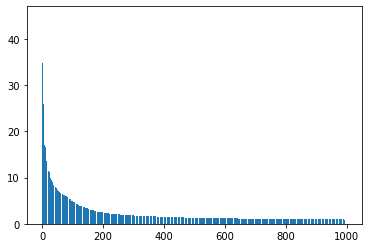

In [ ]:
print('informativeness of genes on individual level')
stds = np.std(arr, axis=0)
stds = sorted(stds, reverse=True)
plt.bar(list(range(len(stds[:1000]))), stds[:1000])
print(stds)

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)  # or 'mle' for auto
PCA_arr = pca.fit_transform(arr_normed)

In [40]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.26872742 0.09135614 0.0630749  0.03133411 0.02537664 0.02263168
 0.0125583  0.01114964 0.00955587 0.00833005 0.00812999 0.00729808
 0.00714566 0.0067019  0.00650331 0.00590219 0.00576815 0.00550526
 0.00539431 0.00481145 0.00472926 0.004546   0.00436609 0.00396897
 0.00380293 0.00373664 0.0035374  0.00351546 0.00345835 0.00344918
 0.00333487 0.00329398 0.00325753 0.00313039 0.00302404 0.00296138
 0.00277844 0.00269879 0.00266864 0.00261994 0.0026086  0.00254482
 0.0025011  0.0024129  0.00236651 0.0023326  0.00233018 0.00225936
 0.00223868 0.00221096 0.00218886 0.00212599 0.00208683 0.0020785
 0.00202999 0.00199993 0.00195227 0.0019267  0.0019121  0.00189954
 0.00185547 0.00184129 0.00179098 0.00175986 0.00173788 0.00171375
 0.00169064 0.00166414 0.00162605 0.00159591 0.00157506 0.00153088
 0.00152789 0.00150281 0.00147506 0.00142588 0.00142061 0.00139766
 0.00138463 0.00136363 0.00134207 0.00132301 0.00129392 0.00127964
 0.00126667 0.00123843 0.00122271 0.00120991 0.00119975 0.00118

In [20]:
np.count_nonzero(pca.components_[0])

16651

Tantalizing to try and visualize data!
Here is why that is kind of risky...

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(arr)

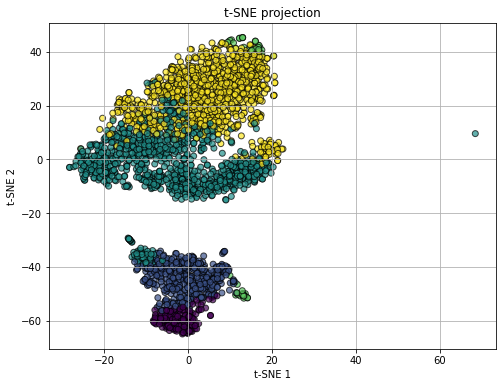

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(arr)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, alpha=0.7, edgecolor='k')
plt.title('t-SNE projection')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
labels2 = kmeans.fit_predict(arr_normed)
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(arr_normed)

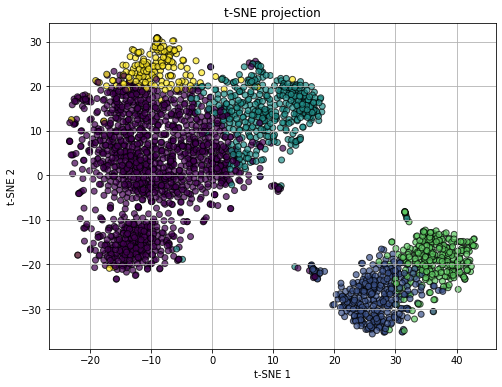

In [30]:
# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels2, alpha=0.7, edgecolor='k')
plt.title('t-SNE projection')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

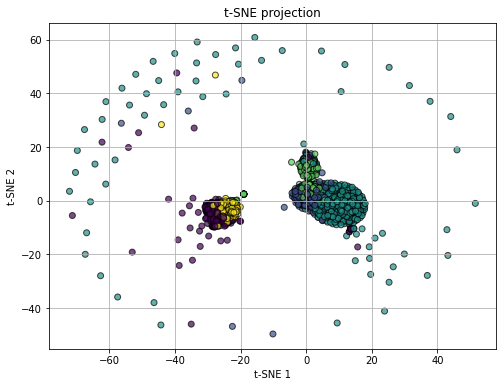

In [32]:
## now do a log transform
LOG_arr_normed = np.log(1 + arr )

kmeans = KMeans(n_clusters=5, random_state=0)
labels3 = kmeans.fit_predict(LOG_arr_normed)
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform( LOG_arr_normed )

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels3, alpha=0.7, edgecolor='k')
plt.title('t-SNE projection')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()